# Experiment - Iris

**References**
* https://archive.ics.uci.edu/ml/datasets/iris

* https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

## Setup

In [32]:
# package versions
!pip list | grep "numpy\|pandas\|torch\|sklearn"

numpy                         1.19.5        
pandas                        1.1.5         
pandas-datareader             0.9.0         
pandas-gbq                    0.13.3        
pandas-profiling              1.4.1         
sklearn                       0.0           
sklearn-pandas                1.8.0         
torch                         1.8.1+cu101   
torchsummary                  1.5.1         
torchtext                     0.9.1         
torchvision                   0.9.1+cu101   


In [33]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
SEED = 42

In [34]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [35]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

iris = load_iris()

scaler = StandardScaler()

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(iris['data']), iris['target'], test_size=0.2, random_state=SEED)

## Data

In [36]:
class IrisDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.from_numpy(data).float()
        self.labels = torch.from_numpy(labels).long()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return item, label

In [37]:
training_data = IrisDataset(X_train, y_train)
test_data = IrisDataset(X_test, y_test)

In [38]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([64, 4]), torch.Size([64]))

## Model

In [39]:
class NN_Model(nn.Module):
    def __init__(self, input_dim):
        super(NN_Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [57]:
class Ada_Act_Params(nn.Module):
    def __init__(self, k0, k1):
        super(Ada_Act_Params, self).__init__()
        self.K = torch.nn.Parameter(torch.tensor([k0, k1]))

    def forward(self, x):
        return self.K[0] + (self.K[1] * x)
    
class Ada_Act_Rand(nn.Module):
    def __init__(self):
        super(Ada_Act_Rand, self).__init__()
        self.values = torch.rand(2)
        self.K = torch.nn.Parameter(torch.tensor(self.values.tolist()))

    def forward(self, x):
        return self.K[0] + (self.K[1] * x)

In [41]:
class NN_Model_Monk(nn.Module):
    def __init__(self, input_dim, k0=None, k1=None):
        super(NN_Model_Monk, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, 3)

        if k0 and k1:
            self.ada_act = Ada_Act_Params(k0, k1)
        else:
            self.ada_act = Ada_Act_Rand()

    def forward(self, x):
        x = self.ada_act(self.layer1(x))
        x = self.ada_act(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [42]:
print(NN_Model_Monk(4))

NN_Model_Monk(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
  (ada_act): Ada_Act_Rand()
)


In [43]:
print(NN_Model_Monk(4, 0.5, 0.5))

NN_Model_Monk(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
  (ada_act): Ada_Act_Params()
)


In [44]:
def train(dataloader, model, loss_fn, optimizer):
    train_loss = []
    pred_all = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        train_loss.append(loss.item())
        pred_all += pred.argmax(1).tolist()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_acc = metrics.accuracy_score(dataloader.dataset.labels, pred_all)
    return (sum(train_loss)/len(train_loss), train_acc)

In [45]:
def test(dataloader, model):
    model.eval()
    test_loss = 0
    pred_all = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            # test_acc += (pred.argmax(1) == y).type(torch.float).sum().item()

            pred_all += pred.argmax(1).tolist()
    
    test_loss /= len(dataloader)
    test_acc = metrics.accuracy_score(dataloader.dataset.labels, pred_all)
    test_f1 = metrics.f1_score(dataloader.dataset.labels, pred_all, average=None)
    
    return (test_loss, test_acc, test_f1)

## Experiment : ReLU

In [46]:
model= NN_Model(training_data.data.shape[1]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 30

train_info = []
test_info = []
for epoch in range(EPOCHS):
    train_epoch = train(train_dataloader, model, loss_fn, optimizer)
    test_epoch = test(test_dataloader, model)
    
    train_info.append(train_epoch)
    test_info.append(test_epoch)
    if epoch % 10 == 9:
        print("EPOCH: {0}, Train loss: {1}, Train acc: {2}, Test loss: {3}, Test acc: {4}, Test F1: {5}".format(
            epoch, train_epoch[0], train_epoch[1], test_epoch[0], test_epoch[1], test_epoch[2]))

print("Done!")

EPOCH: 9, Train loss: 0.9055542647838593, Train acc: 0.8583333333333333, Test loss: 0.8779407143592834, Test acc: 0.9333333333333333, Test F1: [1.         0.875      0.91666667]
EPOCH: 19, Train loss: 0.7633441984653473, Train acc: 0.8666666666666667, Test loss: 0.725165069103241, Test acc: 0.9333333333333333, Test F1: [1.         0.875      0.91666667]
EPOCH: 29, Train loss: 0.6920821368694305, Train acc: 0.925, Test loss: 0.6548207998275757, Test acc: 0.9666666666666667, Test F1: [1.         0.94117647 0.95652174]
Done!


Text(0, 0.5, 'test acc')

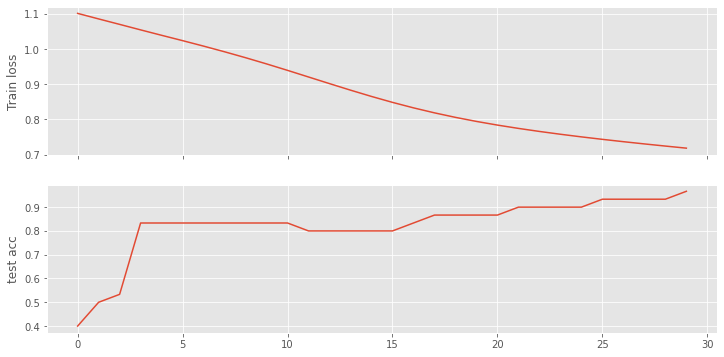

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(list(zip(*train_info))[0])
ax1.set_ylabel("Train loss")
ax2.plot(list(zip(*test_info))[1])
ax2.set_ylabel("test acc")

## Experiment 2: Ada_Act_Params

In [47]:
# set ada_act params
k0 = 0.5
k1 = 0.5

model_monk_params = NN_Model_Monk(training_data.data.shape[1], k0, k1).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_monk_params.parameters(), lr=1e-3)

EPOCHS = 30

train_info = []
test_info = []
for epoch in range(EPOCHS):
    train_epoch = train(train_dataloader, model_monk_params, loss_fn, optimizer)
    test_epoch = test(test_dataloader, model_monk_params)
    
    train_info.append(train_epoch)
    test_info.append(test_epoch)
    if epoch % 10 == 9:
        print("EPOCH: {0}, Train loss: {1}, Train acc: {2}, Test loss: {3}, Test acc: {4}, Test F1: {5}".format(
            epoch, train_epoch[0], train_epoch[1], test_epoch[0], test_epoch[1], test_epoch[2]))

print("Done!")

EPOCH: 9, Train loss: 0.9388868510723114, Train acc: 0.6583333333333333, Test loss: 0.9030010104179382, Test acc: 0.7, Test F1: [0.86956522 0.         0.78571429]
EPOCH: 19, Train loss: 0.7944867014884949, Train acc: 0.8333333333333334, Test loss: 0.7584016919136047, Test acc: 0.9, Test F1: [1.   0.8  0.88]
EPOCH: 29, Train loss: 0.7163310050964355, Train acc: 0.8666666666666667, Test loss: 0.6742479801177979, Test acc: 0.9333333333333333, Test F1: [1.         0.875      0.91666667]
Done!


In [48]:
print(model_monk_params.ada_act.K)

Parameter containing:
tensor([0.4969, 0.5643], requires_grad=True)


Text(0, 0.5, 'test acc')

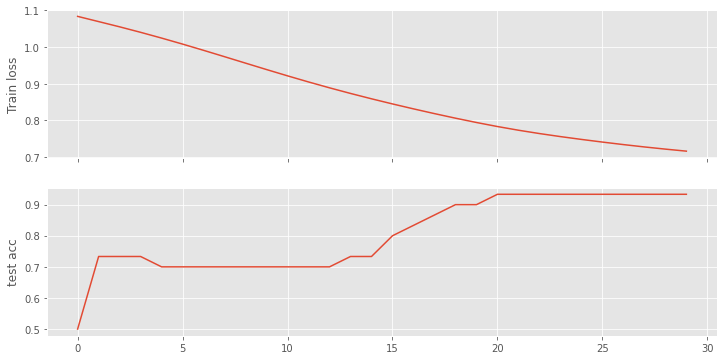

In [49]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(list(zip(*train_info))[0])
ax1.set_ylabel("Train loss")
ax2.plot(list(zip(*test_info))[1])
ax2.set_ylabel("test acc")

## Experiment 3: Ada_Act_Rand

In [62]:
model_monk_rand = NN_Model_Monk(training_data.data.shape[1]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_monk_rand.parameters(), lr=1e-3)

EPOCHS = 30

train_info = []
test_info = []
for epoch in range(EPOCHS):
    train_epoch = train(train_dataloader, model_monk_rand, loss_fn, optimizer)
    test_epoch = test(test_dataloader, model_monk_rand)
    
    train_info.append(train_epoch)
    test_info.append(test_epoch)
    if epoch % 10 == 9:
        print("EPOCH: {0}, Train loss: {1}, Train acc: {2}, Test loss: {3}, Test acc: {4}, Test F1: {5}".format(
            epoch, train_epoch[0], train_epoch[1], test_epoch[0], test_epoch[1], test_epoch[2]))

print("Done!")

EPOCH: 9, Train loss: 0.8950760066509247, Train acc: 0.775, Test loss: 0.8688853979110718, Test acc: 0.8, Test F1: [1.         0.5        0.78571429]
EPOCH: 19, Train loss: 0.7694326639175415, Train acc: 0.8166666666666667, Test loss: 0.736314058303833, Test acc: 0.9333333333333333, Test F1: [1.         0.875      0.91666667]
EPOCH: 29, Train loss: 0.7096844911575317, Train acc: 0.8583333333333333, Test loss: 0.6644108891487122, Test acc: 0.9666666666666667, Test F1: [1.         0.94117647 0.95652174]
Done!


In [60]:
print(model_monk_rand.ada_act.values)

tensor([0.4548, 0.8181])


In [61]:
print(model_monk_rand.ada_act.K)

Parameter containing:
tensor([0.4587, 0.8681], requires_grad=True)


Text(0.5, 0, 'epochs')

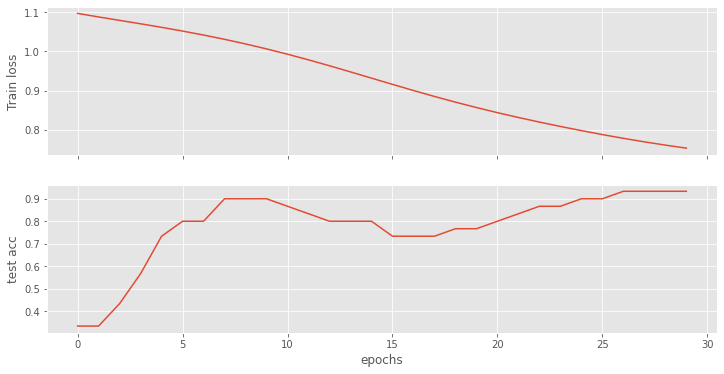

In [53]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(list(zip(*train_info))[0])
ax1.set_ylabel("Train loss")
ax2.plot(list(zip(*test_info))[1])
ax2.set_ylabel("test acc")
ax2.set_xlabel("epochs")